In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras import ops
from keras.layers import TextVectorization

2024-05-06 02:22:49.288659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 02:22:49.948310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/rog-suvab/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

In [3]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [4]:
for _ in range(5):
    print(random.choice(text_pairs))
    

('Hey, I need to talk to you.', '[start] Che, necesito hablar con vos. [end]')
("Tom isn't well today.", '[start] Tom no está bien hoy. [end]')
('We have fun together.', '[start] Nos lo pasamos bien juntos. [end]')
("You don't need to do that.", '[start] No hace falta que hagáis eso. [end]')
("Don't despair.", '[start] ¡No te desesperes! [end]')


In [5]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [6]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

2024-05-06 02:22:50.904836: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 02:22:50.905299: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [8]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


2024-05-06 02:22:52.305005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
import keras.ops as ops


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
            padding_mask = ops.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [10]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,845,120 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 256) │  3,155,456 │ positional_embed… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, None,      │ 12,959,640 │ decoder_inputs[0… │
│ (Functional)        │ 15000)            │            │ transformer_enco… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,960,216 (76.14 MB)

 Trainable params: 19,960,216 (76.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


2024-05-06 02:22:56.450175: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


   1/1302 ━━━━━━━━━━━━━━━━━━━━ 1:31:03 4s/step - accuracy: 0.0000e+00 - loss: 9.6363

2024-05-06 02:22:57.631903: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


   2/1302 ━━━━━━━━━━━━━━━━━━━━ 25:12 1s/step - accuracy: 0.1570 - loss: 9.1833      

2024-05-06 02:22:58.758767: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


   3/1302 ━━━━━━━━━━━━━━━━━━━━ 24:19 1s/step - accuracy: 0.2462 - loss: 8.8697

2024-05-06 02:22:59.879146: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


   4/1302 ━━━━━━━━━━━━━━━━━━━━ 24:17 1s/step - accuracy: 0.3042 - loss: 8.6218

2024-05-06 02:23:00.990800: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


1302/1302 ━━━━━━━━━━━━━━━━━━━━ 1504s 1s/step - accuracy: 0.7119 - loss: 2.2064 - val_accuracy: 0.8041 - val_loss: 1.2291
Epoch 2/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 1488s 1s/step - accuracy: 0.8138 - loss: 1.1874 - val_accuracy: 0.8520 - val_loss: 0.8929
Epoch 3/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 1479s 1s/step - accuracy: 0.8529 - loss: 0.8982 - val_accuracy: 0.8643 - val_loss: 0.7992
Epoch 4/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 1481s 1s/step - accuracy: 0.8690 - loss: 0.7769 - val_accuracy: 0.8737 - val_loss: 0.7410
Epoch 5/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 1470s 1s/step - accuracy: 0.8791 - loss: 0.7032 - val_accuracy: 0.8783 - val_loss: 0.7210
Epoch 6/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 1469s 1s/step - accuracy: 0.8858 - loss: 0.6542 - val_accuracy: 0.8796 - val_loss: 0.7074
Epoch 7/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 1470s 1s/step - accuracy: 0.8918 - loss: 0.6163 - val_accuracy: 0.8816 - val_loss: 0.6990
Epoch 8/30
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 1465s 1s/step - accuracy: 0.8965 - loss: 0.58

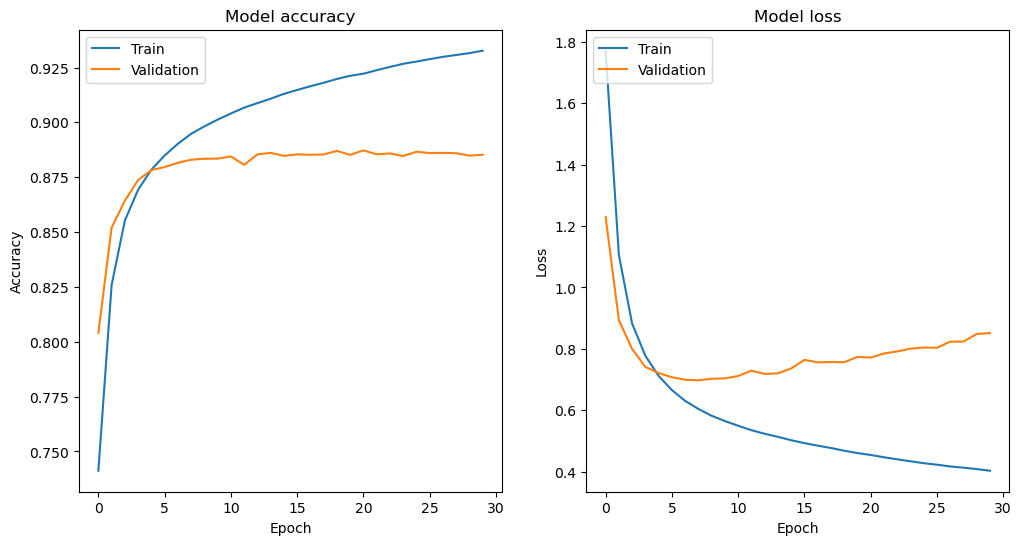

In [11]:
import matplotlib.pyplot as plt

epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Train the model
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Plot training history
import matplotlib.pyplot as plt

def plot_history(history, filename=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    # Plot training & validation accuracy values
    axes[0].plot(history.history["accuracy"])
    axes[0].plot(history.history["val_accuracy"])
    axes[0].set_title("Model accuracy")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend(["Train", "Validation"], loc="upper left")

    # Plot training & validation loss values
    axes[1].plot(history.history["loss"])
    axes[1].plot(history.history["val_loss"])
    axes[1].set_title("Model loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend(["Train", "Validation"], loc="upper left")

    if filename:
        plt.savefig(filename)
    else:
        plt.show()

# Plot the training history
plot_history(history, 'transformerPlot.png')

In [1]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(10):
    input_sentence = random.choice(test_eng_texts)
    print('English: ', input_sentence)
    translated = decode_sequence(input_sentence)
    print('Translated Spanish: ', translated)

NameError: name 'spa_vectorization' is not defined

In [13]:
# import os

# os.environ["KERAS_BACKEND"] = "tensorflow"

# import pathlib
# import random
# import string
# import re
# import numpy as np

# import tensorflow as tf
# import tensorflow.data as tf_data
# import tensorflow.strings as tf_strings

# import keras
# from keras import layers
# from keras import ops
# from keras.layers import TextVectorization
# import string


# text_file = keras.utils.get_file(
#     fname="spa-eng.zip",
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
#     extract=True,
# )
# text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"


# with open(text_file) as f:
#     lines = f.read().split("\n")[:-1]
# english_words = []
# spanish_words = []

# def remove_punctuation(sentence):
#     return sentence.translate(str.maketrans('', '', string.punctuation + '¿¡' ))

# def preprocess_sentence(sentence):
#     return remove_punctuation(sentence).lower()

# for line in lines:
#     eng, spa = line.split("\t")
#     english_words.append(preprocess_sentence(eng))
#     spanish_words.append(preprocess_sentence(spa))


# import re
# from gensim.models import Word2Vec
# import numpy as np

# text_file = keras.utils.get_file(
#     fname="spa-eng.zip",
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
#     extract=True,
# )
# text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"


# with open(text_file) as f:
#     lines = f.read().split("\n")[:-1]
# english_words = []
# spanish_words = []

# def remove_punctuation(sentence):
#     return sentence.translate(str.maketrans('', '', string.punctuation + '¿¡' ))

# def preprocess_sentence(sentence):
#     return remove_punctuation(sentence).lower()

# for line in lines:
#     eng, spa = line.split("\t")
#     english_words.append(preprocess_sentence(eng))
#     spanish_words.append(preprocess_sentence(spa))

# def preprocess_data(text):
#     text = re.sub(r'[^\w\s]', '', text)
#     return text.lower().split()

# english_words = [preprocess_data(word) for word in english_words]
# spanish_words = [preprocess_data(pair) for pair in spanish_words]
# # Flatten the lists of tokens
# english_tokens = [token for sentence in english_words for token in sentence]
# spanish_tokens = [token for sentence in spanish_words for token in sentence]

# english_cbow_model = Word2Vec(sentences=english_words, vector_size=100, window=5, sg=0, min_count=1, epochs=50)
# spanish_cbow_model = Word2Vec(sentences=spanish_words, vector_size=100, window=5, sg=0, min_count=1, epochs=50)

# def map_words_to_vectors(sentences, cbow_model):
#     vectors = []
#     for sentence in sentences:
#         vector = np.mean([cbow_model.wv[word] for word in sentence if word in cbow_model.wv], axis=0)
#         vectors.append(vector)
#     return vectors

# english_vectors = map_words_to_vectors(english_words, english_cbow_model)
# spanish_vectors = map_words_to_vectors(spanish_words, spanish_cbow_model)


# import numpy as np
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.optimizers import Adam

# # Define encoder input
# encoder_inputs = Input(shape=(1000, 1))

# # Define encoder LSTM layers
# encoder_lstm1 = LSTM(256, return_sequences=True, return_state=True)
# encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)

# encoder_lstm2 = LSTM(256, return_sequences=True, return_state=True)
# encoder_outputs, state_h, state_c = encoder_lstm2(encoder_outputs1)
# encoder_states = [state_h, state_c]

# # Define decoder input
# decoder_inputs = Input(shape=(100, 1))

# # Define decoder LSTM layer
# decoder_lstm1 = LSTM(256, return_sequences=True, return_state=True)
# decoder_outputs1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states)

# # Define attention mechanism
# attention_layer = Attention()
# attention_out = attention_layer([decoder_outputs1, encoder_outputs])

# # Concatenate attention output and decoder output
# decoder_concat_input = Concatenate(axis=-1)([decoder_outputs1, attention_out])

# # Define output layer
# decoder_dense = Dense(1, activation='softmax')
# decoder_outputs = decoder_dense(decoder_concat_input)

# # Define the model
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# # Compile the model
# optimizer = Adam(learning_rate=0.0001)
# model.compile(optimizer=optimizer, loss='mse')

# model.summary()

In [14]:
from tensorflow.keras.utils import plot_model
import graphviz
import pydot
import pydotplus
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

NameError: name 'model' is not defined